## 1 - Document Loading

Note that some word files may have extraction issues in that case it is better to convert it to a pdf before doing so.
This part can be extended to other document types using other methods. Currently this loads PDF documents and most Word documents (can be extented to excel or combined with an )

In [ ]:
import os
from typing import List
from langchain.document_loaders import PyPDFLoader
from langchain.schema import Document
from docx import Document as DocxDocument
from langchain.document_loaders.base import BaseLoader
from PyPDF2 import PdfReader

class DocxLoader(BaseLoader):
    def __init__(self, file_path: str):
        self.file_path = file_path

    def load(self) -> List[Document]:
        doc = DocxDocument(self.file_path)
        text = ""
        for para in doc.paragraphs:
            text += para.text + "\n"
        for table in doc.tables:
            for row in table.rows:
                for cell in row.cells:
                    for para in cell.paragraphs:
                        text += para.text + "\n"
        metadata = {
            "title": os.path.basename(self.file_path),
            "page": 1  # No way to get page count from docx files
        }
        return [Document(page_content=text, metadata=metadata)]

def extract_text_from_pdf(file_path):
    reader = PdfReader(open(file_path, "rb"))
    text_pages = []
    for i, page in enumerate(reader.pages):
        text = page.extract_text()
        text_pages.append({"text": text, "page": i + 1})
    return text_pages

def extract_text_and_metadata(file_path, filename):
    if file_path.endswith(".pdf"):
        text_pages = extract_text_from_pdf(file_path)
        documents = []
        for page in text_pages:
            metadata = {"title": filename, "page": page["page"]}
            documents.append({"text": page["text"], "metadata": metadata})
    elif file_path.endswith(".docx"):
        loader = DocxLoader(file_path)
        documents = loader.load()
        if not documents:
            return []
        text = documents[0].page_content
        metadata = documents[0].metadata
        documents = [{"text": text, "metadata": metadata}]
    else:
        return []
    
    return documents

# Directory containing the files
directory = "/documents/files"

all_documents = []

# Loop through files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".pdf") or filename.endswith(".docx"):
        file_path = os.path.join(directory, filename)
        documents = extract_text_and_metadata(file_path, filename)
        all_documents.extend(documents)
        for doc in documents:
            print(f"File: {filename}")
            print("Metadata:", doc["metadata"])
            print("Text preview:", doc["text"][:500])
            print("Text length:", len(doc["text"]))
            print("="*40)

# 2 - Document Splitting

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

# Initialize text splitters
chunk_size = 1000
chunk_overlap = 150
separators=["\n\n", "\n", "(?<=\. )", " ", ""]

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=separators
)

# List to store split texts
split_documents = []

# Perform text splitting
for doc in all_documents:
    text = doc["text"]
    metadata = doc["metadata"]
    splits = r_splitter.split_text(text)
    for i, split in enumerate(splits):
        split_metadata = metadata.copy()
        split_metadata["split_number"] = i + 1
        split_documents.append({"text": split, "metadata": split_metadata})

# Print out some splits to verify
for i, split_doc in enumerate(split_documents[:20]):
    print(f"Split {i + 1}:")
    print("Metadata:", split_doc["metadata"])
    print(split_doc["text"])
    print("="*40)

Average chunk length: 732.8140703517588 characters


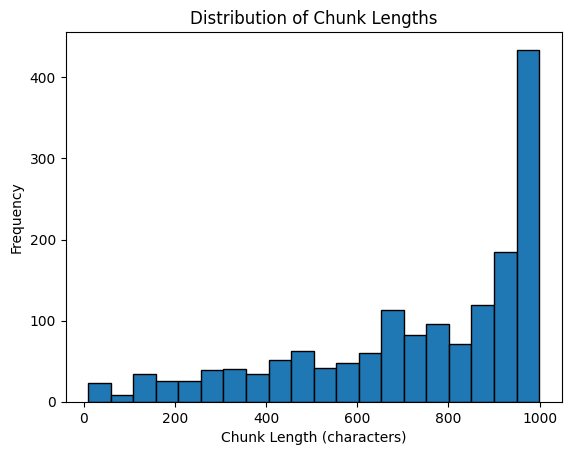

In [8]:
# Function to calculate average length of chunks
def average_chunk_length(split_docs):
    total_length = sum(len(doc['text']) for doc in split_docs)
    return total_length / len(split_docs)

print(f"Average chunk length: {average_chunk_length(split_documents)} characters")

# Checking the distribution of chunk lengths
import matplotlib.pyplot as plt

chunk_lengths = [len(doc['text']) for doc in split_documents]
plt.hist(chunk_lengths, bins=20, edgecolor='black')
plt.title('Distribution of Chunk Lengths')
plt.xlabel('Chunk Length (characters)')
plt.ylabel('Frequency')
plt.show()

# 3 - Embedddings and Vectorstores

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
import numpy as np
from datetime import datetime

def filter_complex_metadata(metadata):
    for key, value in metadata.items():
        if isinstance(value, datetime):
            metadata[key] = value.isoformat()
    return metadata

# Initialize OpenAI embeddings
embedding = OpenAIEmbeddings(
    model="text-embedding-ada-002",
    openai_api_key="sk-proj-addkey"  
)

# Convert split_documents to Document objects
document_objects = [
    Document(
        page_content=doc["text"], 
        metadata=filter_complex_metadata(doc["metadata"])
    ) 
    for doc in split_documents
]

# Create a vector store and add documents in batches
batch_size = 16
vectordb = None

persist_directory = "Y:/Community Project/UC2/WVC chatbot/vectordb/vectordb_kenya_files"

for i in range(0, len(document_objects), batch_size):
    batch = document_objects[i:i + batch_size]
    if vectordb is None:
        vectordb = Chroma.from_documents(batch, embedding, persist_directory=persist_directory)
    else:
        vectordb.add_documents(batch)
        

print(f"Number of documents in vector store: {vectordb._collection.count()}")

print(f"Vector store saved to {persist_directory}")


#### Saving the vector store locally

In [ ]:
question = "From the ***** qualitative report, in which countries did it take place"
docs = vectordb.similarity_search(question, k=5)

# Print results
for i, doc in enumerate(docs):
    print(f"Document {i + 1}:")
    print("Text:", doc.page_content)
    print("Metadata:", doc.metadata)
    print("="*40)

# Cannot display the results as the documents used for this project are confidential

## 4 - Retrieval

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo

metadata_field_info = [
    AttributeInfo(
        name="title",
        description="The title of the document",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page number of the chunk",
        type="integer",
    ),
    AttributeInfo(
        name="split_number",
        description="The chunk split number",
        type="integer",
    ),
]

document_content_description = "Documents from **** files"

llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key="sk-proj-sk-proj-addkey")

retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    verbose=True
)

question = "What were the highlights relative to Kenya in 2019?"

docs = retriever.get_relevant_documents(question)

for i, doc in enumerate(docs):
    print(f"Document {i + 1}:")
    print("Metadata:", doc.metadata)
    print("Text:", doc.page_content[:400])
    print("="*40)

# Output hidden as the documents used for this project are confidential
# output format: Document 1: Metadata: {'title': 'filename', 'page': 1, 'split_number': 1} Text: text preview

## 5 - Chatbot Example

In [12]:
from langchain.prompts import PromptTemplate
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.llms import OpenAI

# Define the prompt template
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

# Memory for the conversational chain
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="answer"  # Explicitly set the output key
)

llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key="sk-proj-sk-proj-addkey")

# ConversationalRetrievalChain with max_marginal_relevance_search
retriever = vectordb.as_retriever(search_type="mmr", search_kwargs={"k": 5})

# Create the ConversationalRetrievalChain
qa_chain = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    return_generated_question=True,
    condense_question_prompt=QA_CHAIN_PROMPT
)

In [ ]:

# Example question
question = "What were the outcomes relative to **** project in ****?"

result = qa_chain.invoke({"question": question})

print("Answer:")
print(result['answer'])
print("\nSource Documents:")
for i, doc in enumerate(result['source_documents']):
    print(f"Document {i + 1}:")
    print("Metadata:", doc.metadata)
    print("Text:", doc.page_content[:400])
    print("="*40)